# A Guide On Solving Non-Convex Consumption-Saving Models

This notebook produces the timing and accuracy results for the benchmark model in [A Guide to Solve Non-Convex Consumption-Saving Models](https://doi.org/10.1007/s10614-020-10045-x).

**Computer used for timings:** Windows 10 computer with 2x Intel(R) Xeon(R) Gold 6254 3.10 GHz CPUs (18 cores, 36 logical processes each) and 768 GB of RAM.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import tabs
from figs import lifecycle_compare

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Choose number of threads in numba

In [2]:
import numba as nb
nb.set_num_threads(8)

# Timing function

In [3]:
def run(name = 'baseline',
        rep = 1, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()    

    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

# Settings

In [4]:
load = False
load_negm = load
load_nvfi = load
load_vfi = load

T = 10
models = dict()

# baseline
basename = 'results'
base = dict()
base['Np'] = 150
base['Nn'] = 150
base['Nm'] = 300
base['Nx'] = 300
base['Na'] = 300
base['T'] = T

model = DurableConsumptionModelClass(name='')


# Timings

In [6]:
models['negm'] = run(name=f'{basename}',load=load_negm,solmethod='negm',updpar=base)
models['nvfi'] = run(name=f'{basename}',load=load_nvfi,solmethod='nvfi',updpar=base)

0: total time = 30.52

Name: results (solmethod = negm)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 30.5
     w: 19.1
  keep: 11.1
   adj: 0.3
Utility: -9.807519
Euler errors:
     total: -4.42 (-5.65,-3.17)
   keepers: -4.43 (-5.66,-3.14)
 adjusters: -4.32 (-5.41,-3.35)
Moments:
 adjuster share: 0.183
         mean c: 1.024
          var c: 0.099
         mean d: 0.496
          var d: 0.047

checksum, inv_v_keep: 0.14725274
checksum, inv_v_adj: 0.14793491

0: total time = 83.82

Name: results (solmethod = nvfi)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 83.8
     w: 11.6
  keep: 71.8
   adj: 0.4
Utility: -9.807520
Euler errors:
     total: -3.91 (-5.11,-2.89)
   keepers: -3.93 (-5.13,-2.89)
 adjusters: -3.65 (-4.65,-2.91)
Moments:
 adjuster share: 0.183
         mean c: 1.024
          var c: 0.099
         mean d: 0.496
          var d: 0.047

checksum, inv_v_keep: 0.14725275
checksum, inv_v_adj: 0.14793495



# Tables

In [10]:
main_models = [models['nvfi'],models['negm']]
tabs.all(main_models,postfix='_python')

# Figures

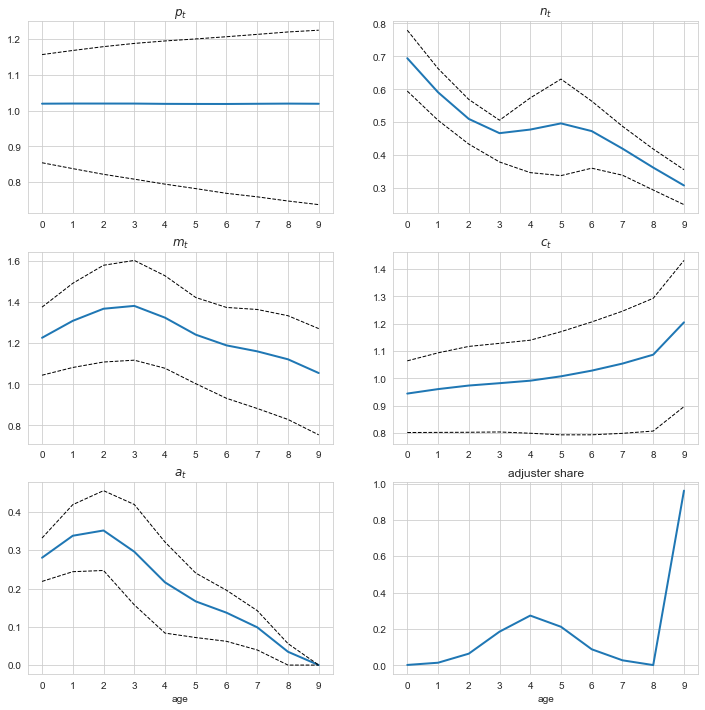

In [11]:
models['negm'].lifecycle()

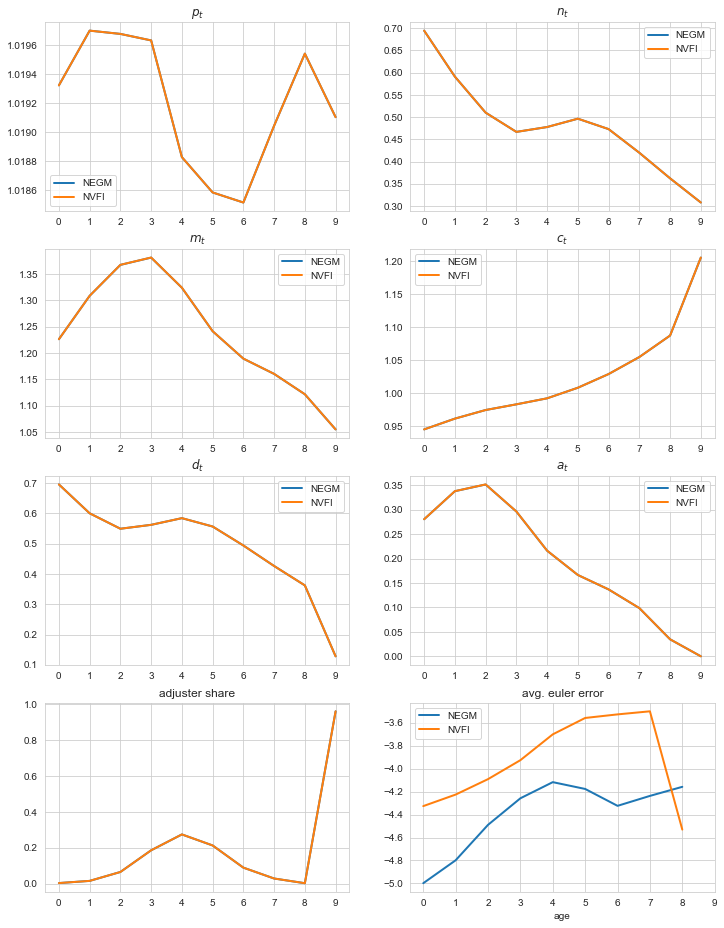

In [12]:
lifecycle_compare(models['negm'],'NEGM',models['nvfi'],'NVFI',do_euler_errors=True)